In [1]:
import numpy as np
import h5py, os

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
plt.rcParams["font.family"] = "serif"
plt.style.use('classic')
font = font_manager.FontProperties(family='serif', size=16)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader 

# Variational Autoencoders for Anomaly Detection at the LHC

## The physics problem
"[...]given the (so far) negative outcome of many
BSM searches at particle-physics experiments, it is possible that a future BSM model, if
any, is not among those typically tested.[...]\
It is possible to imagine BSM scenarios that would escape detection, simply because the corresponding new physics events would be rejected by a typical set of online selection
algorithms. Establishing alternative search methodologies with reduced model dependence is an
important aspect of future LHC runs. [...]

We consider the case of a typical single-lepton data stream, selected
by a hardware-based Level-1 (L1) trigger system. 
[...] we imagine to replace
this model-dependent selection with a variational autoencoder (VAE). The VAE is trained to compress the input event representation into a lower-dimension latent space and then decompress it,
returning the shape parameters describing the probability density function (pdf) of each
input quantity given a point in the compressed space. [...]\
The distribution of the VAE’s reconstruction loss on a validation sample is used to
define a threshold, corresponding to a desired acceptance rate for SM events. All the events
with loss larger than the threshold are considered as potential anomalies [...] " 

*from "Variational Autoencoders for New Physics Mining at the Large Hadron Collider" (https://arxiv.org/pdf/1811.10276)*


#### More about the physics problem:
- *"Variational Autoencoders for New Physics Mining at the Large Hadron Collider"* https://arxiv.org/pdf/1811.10276
- *"Autoencoders on FPGAs for real-time, unsupervised new physics detection at 40 MHz at the Large Hadron Collider"* https://arxiv.org/pdf/2108.03986
- Anomaly detection challenge: *"Unsupervised New Physics detection at 40 MHz"* https://mpp-hep.github.io/ADC2021

## Dataset
"In the particle detectors at the Large Hadron Collider, hundreds of millions of proton-proton collisions are produced every second. If one could store the whole data stream produced in these collisions, tens of terabytes of data would be written to disk every second. The general-purpose experiments ATLAS and CMS reduce this overwhelming data volume to a sustainable level, by deciding in real-time whether each collision event should be kept for further analysis or be discarded. [in this tutorial] We consider a dataset of proton collision events that emulates a typical data stream collected by such a real-time processing system, pre-filtered by requiring the presence of at least one electron or muon."

*from "LHC physics dataset for unsupervised New Physics detection at 40 MHz" (https://doi.org/10.1038/s41597-022-01187-8)*

The dataset consists of simulated events for the Standard Model (SM) and four beyond the Standard Model signatures: 
    - $A\rightarrow 4l$: a neutral scalar boson ($A$) decaying to two off-shell Z bosons, each forced to decay to two leptons;
    - $h^{\pm}\rightarrow \tau^{\pm}\nu$: a charged scalar boson ($h^{\pm}$) decaying to a $\tau$ lepton and a neutrino;
    - $h^0 \rightarrow \tau^+\tau^-$: a scalar boson ($h^0$) decaying to two $\tau$ leptons;
    - ${\rm LQ}\rightarrow b\tau$: a leptoquark (LQ) decaying to a $b$ quark and a $\tau$ lepton.
    
Each dataset contains a list of collision events. Each collision is represented by a set of 19 physics objects (4 muons, 4 electrons, 10 jets and the event missing transverse energy). Each object is characterised by three kinematic variables and a class label, for a total of 76 features.

#### links to datasets (on Zenodo):
- SM background:   https://doi.org/10.5281/zenodo.5046388
- $A\rightarrow 4l$:     https://doi.org/10.5281/zenodo.5046445
- $h^{\pm}\rightarrow \tau^{\pm}\nu$:  https://doi.org/10.5281/zenodo.7152617
- $h^{0}\rightarrow \tau\tau$:   https://doi.org/10.5281/zenodo.7152614
- LQ$\rightarrow b\tau$:  https://doi.org/10.5281/zenodo.7152599
- blackbox:    https://doi.org/10.5281/zenodo.5072068
  


## Variational Autoencoders
As discussed in the Lecture, a variational auto-encoder is a deep latent variable model where:
- The prior $p(z)$ is prescribed, and usually chosen to be Gaussian.
- The likelihood $p(x∣z)$ is parameterized with a generative network ${\rm NN}_\theta$
  (or decoder) that takes as input $z$ and outputs parameters $\phi={\rm NN}_\theta(z)$ to the data distribution.
  E.g.,
  $$\mu, \, \sigma = {\rm NN}_{\theta}(z)$$
  $$p_{\theta}(x|z)=N(x;\,\mu, \sigma^2\mathbb{I})$$
- The approximate posterior $q_\phi(z|x)$ is parameterized with an inference network ${\rm NN}_{\phi}$ (or encoder) that takes as input $x$ and outputs parameters $\nu = {\rm NN}_{\phi}(x)$ to the approximate posterior. E.g.,
  $$\mu, \, \sigma = {\rm NN}_{\phi}(x)$$
  $$p_{\theta}(z|x)=N(z;\,\mu, \sigma^2\mathbb{I})$$
<figure>
    <img src="./figures/VAE_louppe.png"
         alt="G. Louppe">
    <figcaption>Variational Autoencoders <a href=https://glouppe.github.io/info8010-deep-learning/?p=lecture11.md#45" target="_blank">Lecture</a> - G. Louppe </figcaption>
</figure>

  
The ML side of this tutorial is built on https://github.com/Jackson-Kang/Pytorch-VAE-tutorial \
The physics side of this tutorial relies on https://github.com/mpp-hep/ADC2021-examplecode/tree/main 

## Data loading utils
(some useful function to load the data and normalize the features)

In [2]:
def h5_loader(file_path: str='background_for_training.h5', min_pt=None, max_pt=None, mean_eta=None, std_eta=None, mean_phi=None, std_phi=None, min_class=None, max_class=None):
    ff = h5py.File(file_path, 'r')
    particles = np.asarray(ff.get('Particles'))
    particles = normalize_features(particles, min_pt, max_pt, mean_eta, std_eta, mean_phi, std_phi, min_class, max_class).reshape((-1, 19*4))
    particles = torch.from_numpy(particles)
    print(particles.shape)
    return particles

def summary_statistics(file_path: str='background_for_training.h5'):
    ff = h5py.File(file_path, 'r')
    particles = np.asarray(ff.get('Particles'))
    idx_pt, idx_eta, idx_phi, idx_class = range(4)
    min_pt    = np.min(particles[:,:,idx_pt])
    max_pt    = np.max(particles[:,:,idx_pt])
    mean_eta  = np.mean(particles[:,:,idx_eta])
    std_eta   = np.std(particles[:,:,idx_eta])
    mean_phi  = np.mean(particles[:,:,idx_phi])
    std_phi   = np.std(particles[:,:,idx_phi])
    min_class = np.min(particles[:,:,idx_class])
    max_class = np.max(particles[:,:,idx_class])
    return min_pt, max_pt, mean_eta, std_eta, mean_phi, std_phi, min_class, max_class

def normalize_features(particles, min_pt=None, max_pt=None, mean_eta=None, std_eta=None, mean_phi=None, std_phi=None, min_class=None, max_class=None):
    idx_pt, idx_eta, idx_phi, idx_class = range(4)
    if min_pt==None: min_pt    = np.min(particles[:,:,idx_pt])
    if max_pt==None: max_pt    = np.max(particles[:,:,idx_pt])
    if mean_eta==None: mean_eta  = np.mean(particles[:,:,idx_eta])
    if std_eta==None: std_eta   = np.std(particles[:,:,idx_eta])
    if mean_phi==None: mean_phi  = np.mean(particles[:,:,idx_phi])
    if std_phi==None: std_phi   = np.std(particles[:,:,idx_phi])
    if min_class==None: min_class = np.min(particles[:,:,idx_class])
    if max_class==None: max_class = np.max(particles[:,:,idx_class])
    # min-max normalize pt
    particles[:,:,idx_pt] = (particles[:,:,idx_pt] - min_pt) / (max_pt-min_pt)
    # standard normalize angles
    particles[:,:,idx_eta] = (particles[:,:,idx_eta] - mean_eta)/std_eta
    particles[:,:,idx_phi] = (particles[:,:,idx_phi] - mean_phi)/std_phi
    # min-max normalize class label
    particles[:,:,idx_class] = (particles[:,:,idx_class] - min_class) / (max_class-min_class)
    return particles

# Model design
A simple implementation of Gaussian MLP Encoder and Decoder

In [3]:
class Encoder(nn.Module):
    '''
    encoder produces mean and log of variance 
    (i.e., parateters of simple tractable normal distribution "q"
    '''
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.FC_input = nn.Linear(input_dim, hidden_dim[0])
        self.FC_hidden = nn.ModuleList([nn.Linear(hidden_dim[i], hidden_dim[i+1]) for i in range(len(hidden_dim)-1)])
        #self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim[-1], latent_dim)
        self.FC_var   = nn.Linear (hidden_dim[-1], latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True
        
    def forward(self, x):
        h = self.LeakyReLU(self.FC_input(x))
        for i, FC in enumerate(self.FC_hidden):
            h = self.LeakyReLU(FC(h))
        mean = self.FC_mean(h)
        log_var = self.FC_var(h)
        return mean, log_var
        
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_latent = nn.Linear(latent_dim, hidden_dim[0])
        self.FC_hidden = nn.ModuleList([nn.Linear(hidden_dim[i], hidden_dim[i+1]) for i in range(len(hidden_dim)-1)])
        self.FC_output = nn.Linear(hidden_dim[-1], output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h = self.LeakyReLU(self.FC_latent(x))
        for i, FC in enumerate(self.FC_hidden):
            h = self.LeakyReLU(FC(h))
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

class Model(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim_encoder, hidden_dim_decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim_encoder, latent_dim=latent_dim)
        self.Decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim_decoder, output_dim=input_dim)
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)  # sampling epsilon        
        z = mean + var*epsilon       # reparameterization trick
        return z
        
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.Decoder(z)
        return x_hat, mean, log_var

def AllLoss(x, x_hat, mean, log_var, lambda_kld):
    Reco = RecoLoss(x_hat, x)
    KLD  = KLDLoss(mean, log_var)
    return Reco + lambda_kld*KLD, Reco, lambda_kld*KLD

def RecoLoss(x_hat, x, reduction='sum'):
    return nn.functional.binary_cross_entropy(x_hat, x, reduction=reduction)
    
def KLDLoss(mean, log_var, reduction='sum'):
    if reduction=='sum':
        return - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    elif reduction=='none':
        return - 0.5 * (1+ log_var - mean.pow(2) - log_var.exp())

# Load training data
Let's start by loading the data (normalization is taken cared within the loading process)

In [4]:
dataset_path = './background_for_training.h5'
if not os.path.exists(dataset_path):
    !pip3 install zenodo_get
    !zenodo_get "10.5281/zenodo.5046388"
    
# compute standardization statistics
min_pt, max_pt, mean_eta, std_eta, mean_phi, std_phi, min_class, max_class= summary_statistics(file_path=dataset_path)

In [5]:
N_train = 1000000
N_test = 1000000
N_val = 1000000

dataset = torch.utils.data.TensorDataset(h5_loader(dataset_path, min_pt, max_pt, mean_eta, std_eta, mean_phi, std_phi, min_class, max_class))
train_dataset = dataset[:N_train, :]
val_dataset  = dataset[N_train:N_train+N_val, :]
test_dataset  = dataset[N_train+N_val:N_train+N_val+N_test, :]

torch.Size([13451915, 76])


#### visualize training data
when working on a dataset for the first time, it is always useful to plot a subset of the training points and obeserve the relevant properties of the dataset. In the following we plot the marginals of the training data distribution. From the plots it becomes evident a peculiar feature of this dataset, often referred to as *zero padding*, namely the practice of filling with zeros the entries corresponding to specific objects that are not observed in the event.

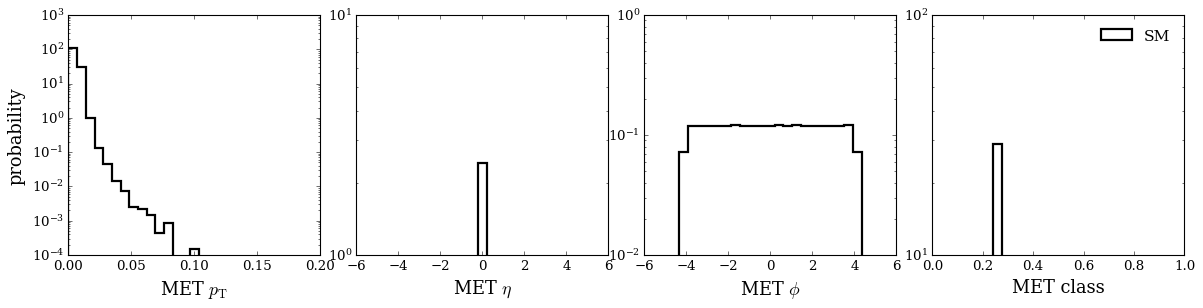

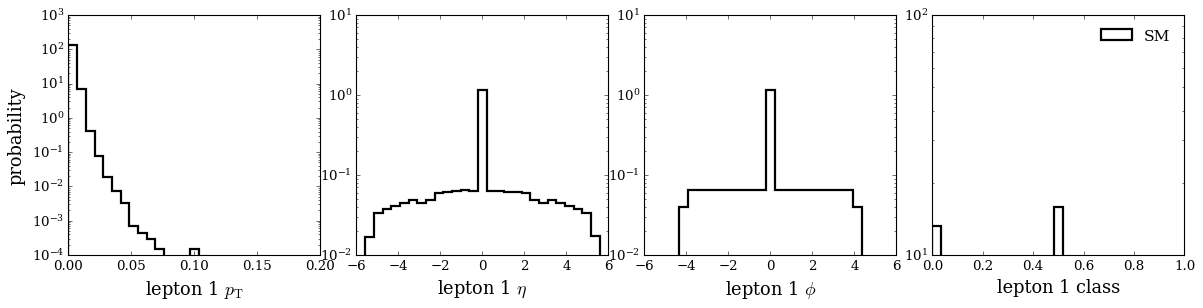

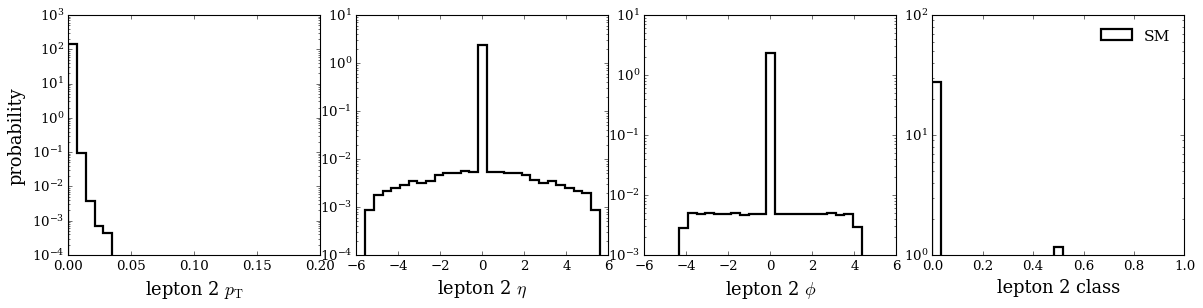

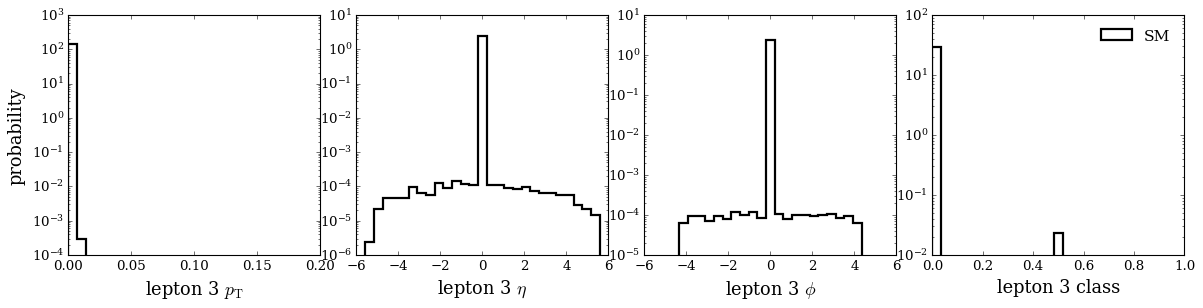

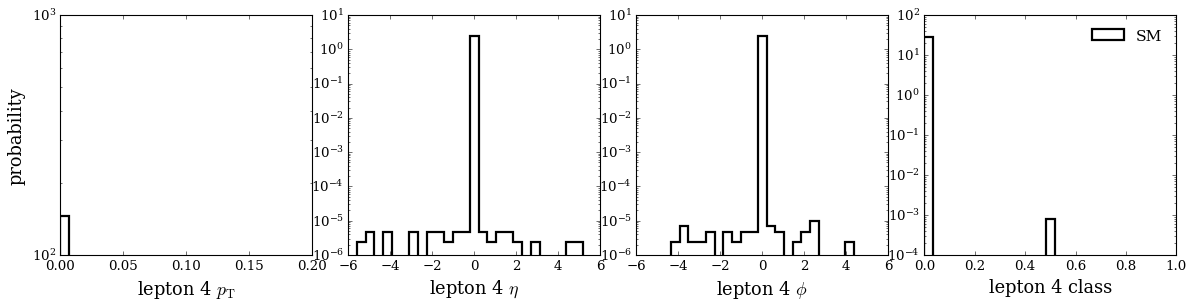

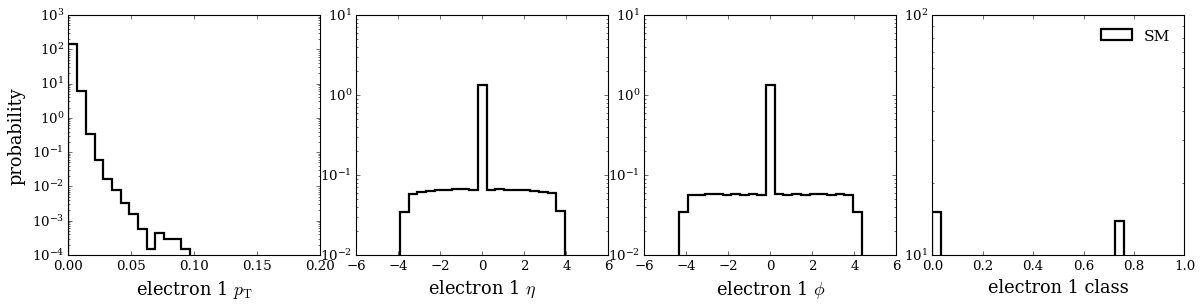

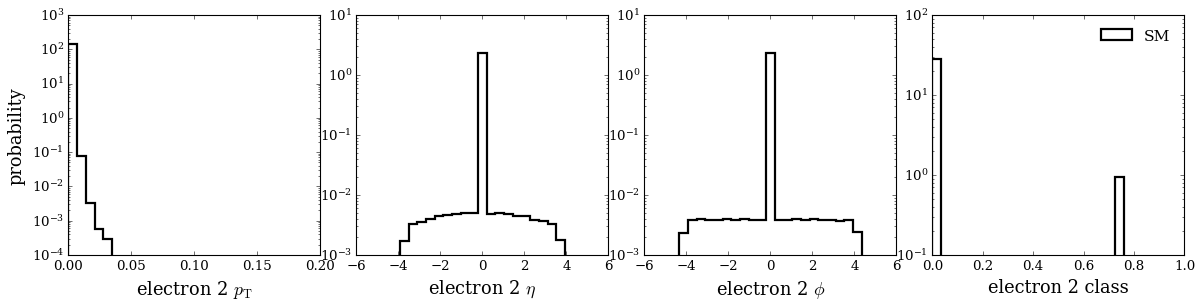

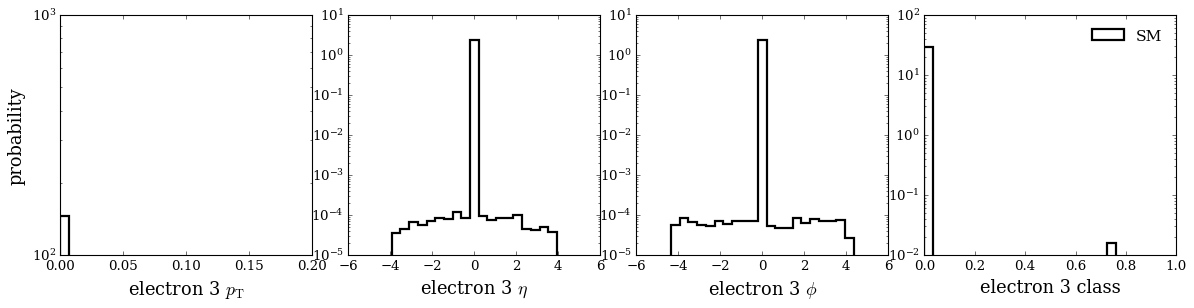

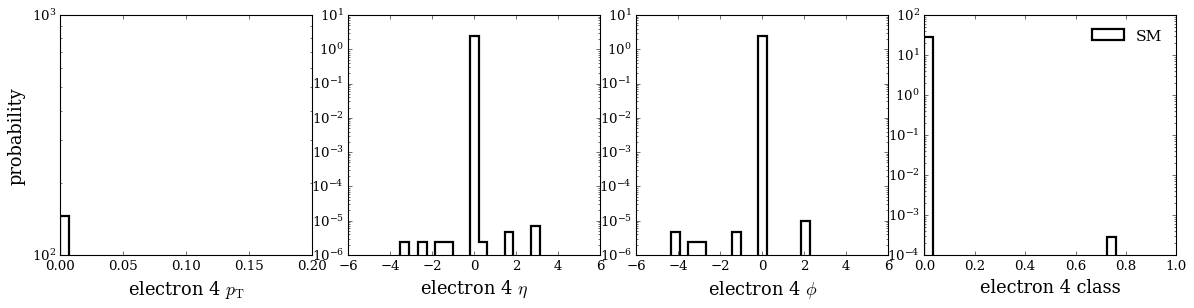

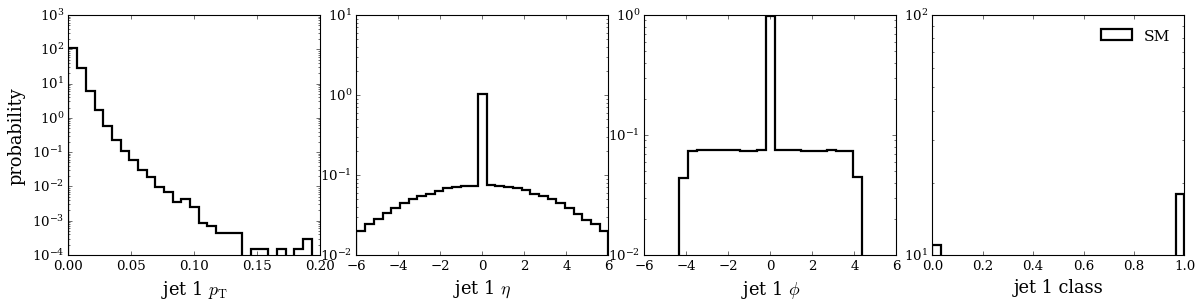

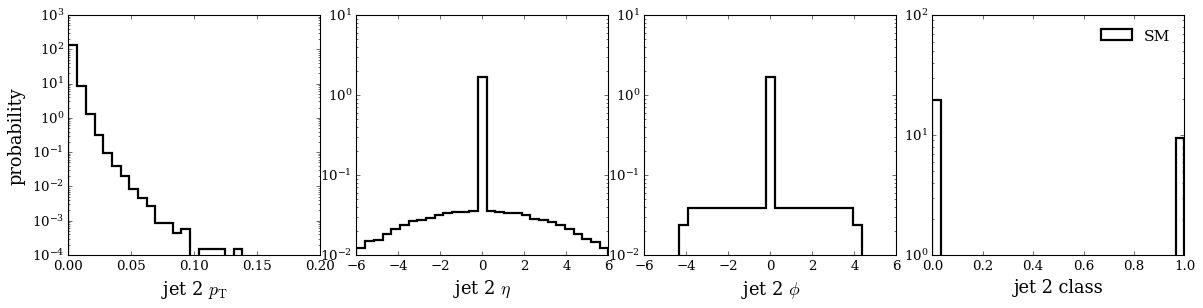

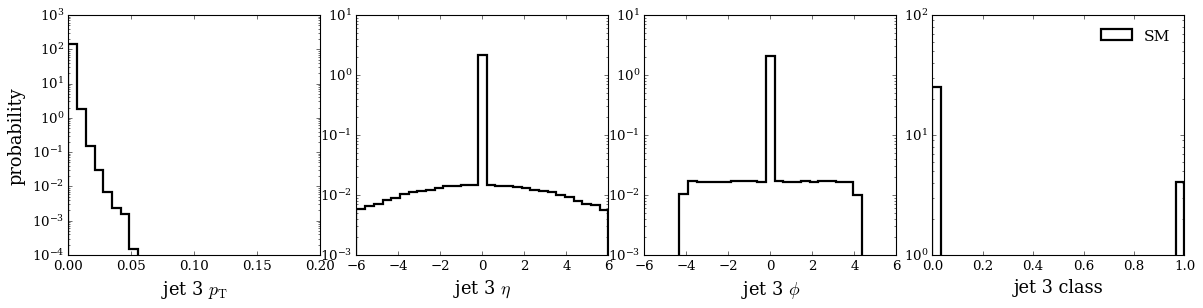

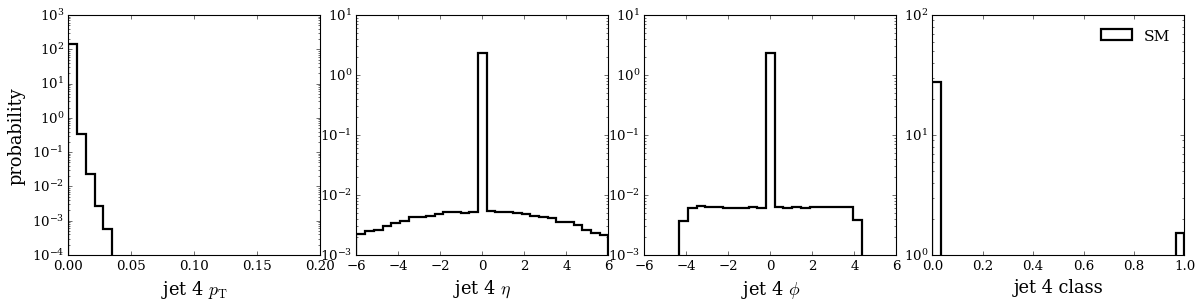

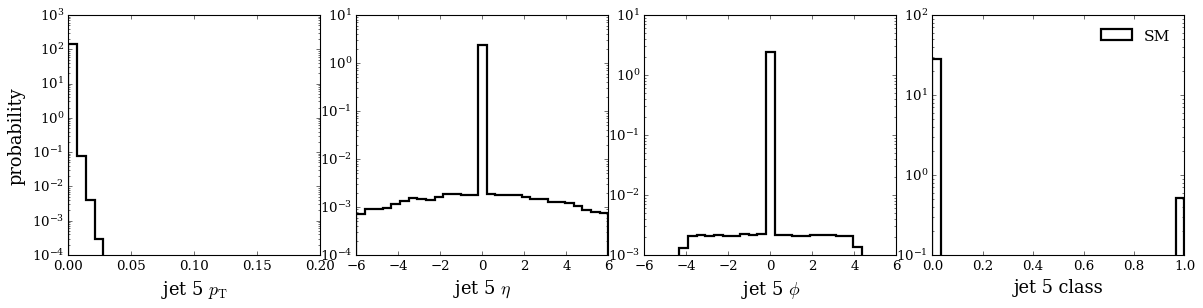

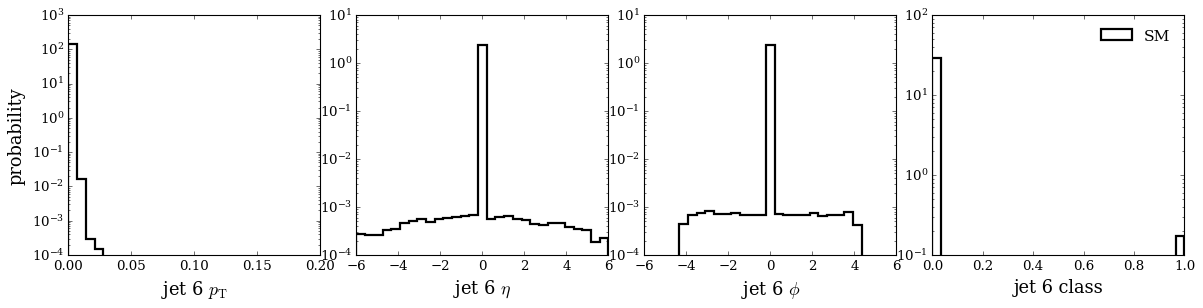

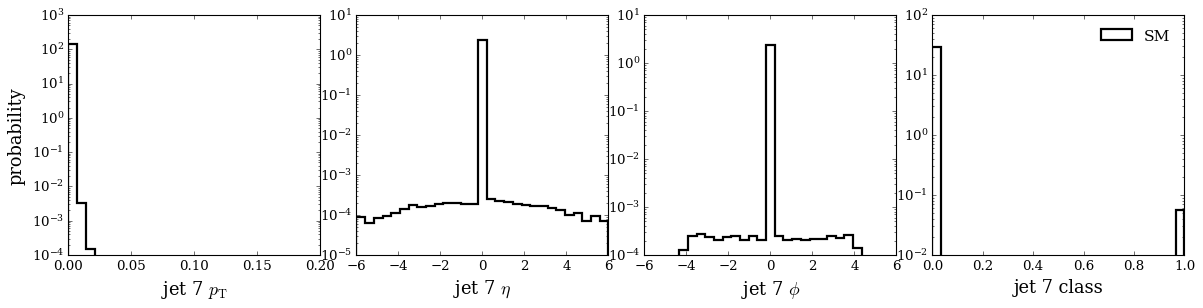

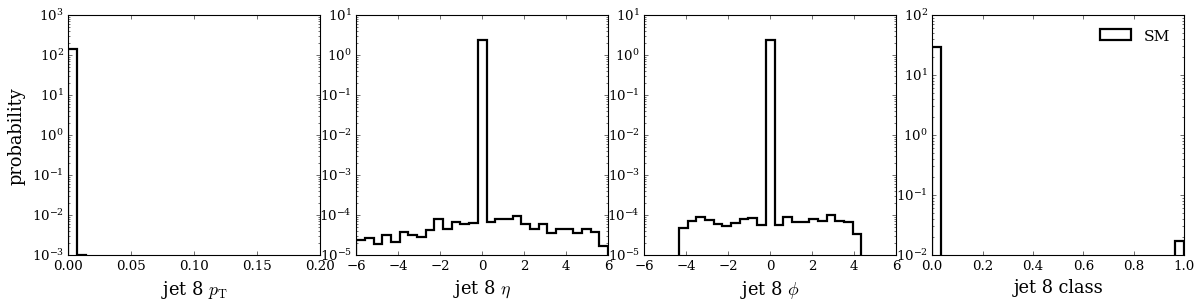

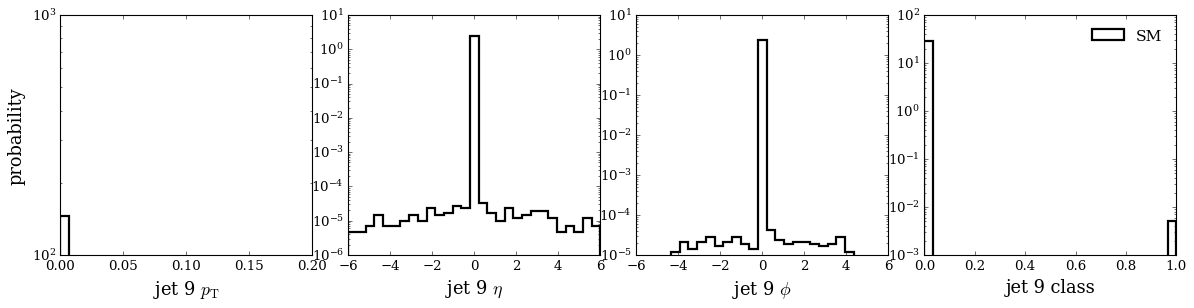

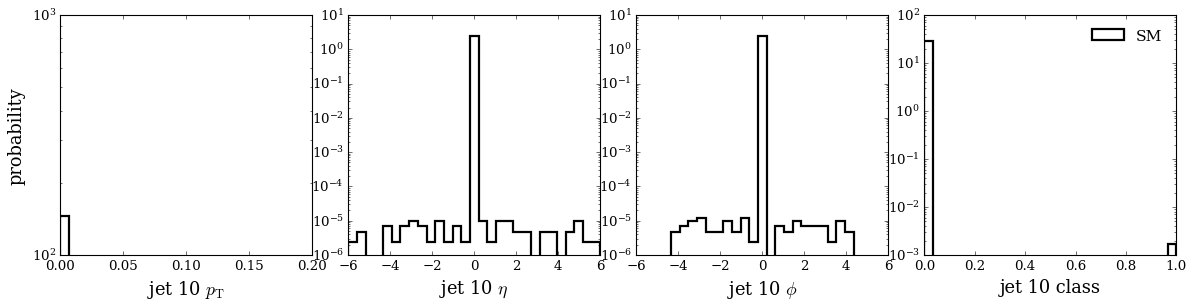

In [6]:
xlabel = [r'$p_{\rm T}$', r'$\eta$', r'$\phi$', 'class']
obj_label = ['MET', 
             'lepton 1', 'lepton 2', 'lepton 3', 'lepton 4', 
             'electron 1', 'electron 2', 'electron 3', 'electron 4',
             'jet 1', 'jet 2', 'jet 3', 'jet 4', 'jet 5', 'jet 6', 'jet 7', 'jet 8', 'jet 9', 'jet 10'
        ]
bins = [
    np.linspace(0, 0.5, 30),
    np.linspace(-6, 6, 30),
    np.linspace(-6, 6, 30),
    np.linspace(0, 1, 30),
       ]
sm= test_dataset[0]
sm=sm.view(-1, sm.shape[1]).float()
sm=sm.cpu()
for i in range(19):
    fig = plt.figure(figsize=(15, 4))
    fig.patch.set_facecolor('white')
    for j in range(4):
        ax = fig.add_axes([0.05+0.24*j+(i*4), 0.2, 0.21, 0.75])
        h = plt.hist(sm[:, j+(i*4)], density=True, color='black', bins=bins[j], lw=2, histtype='step', label='SM')
        ax.set_yscale('log')
        plt.xlabel(obj_label[i]+' '+xlabel[j], fontsize=16, fontname='serif')
        plt.xticks(fontsize=12, fontname='serif')
        plt.yticks(fontsize=12, fontname='serif')
        
        if j==0:
            plt.ylabel('probability', fontsize=16, fontname='serif')
            font = font_manager.FontProperties(family='serif', size=14)
            plt.xscale('log')
        if j==3:
            ax.legend(prop=font, loc='best', frameon=False)
    #plt.savefig('./input_features_obj%i.pdf'%(i))
    plt.show()

# Model initialization
here we specify the main hyper-parameters of the model and the training task

In [7]:
# hyper-paramters of the model
hidden_dim_encoder = # ADD !!!
hidden_dim_decoder = # ADD !!!
latent_dim = # ADD !!!
input_dim = # ADD !!!
lr = 1e-3
lambda_kld = # ADD !!!
batch_size = # ADD !!!
epochs = # ADD !!!

cuda = True # train on GPU?
DEVICE = torch.device("cuda" if cuda else "cpu")

# path to save checkpoint
checkpoint_path = './VAE-checkpoint'

# initialize model
model = Model(input_dim=input_dim, latent_dim=latent_dim, 
              hidden_dim_encoder=hidden_dim_encoder, 
              hidden_dim_decoder=hidden_dim_decoder).to(DEVICE)

# initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Model training

#### initialize a dictionary to record the training history
It is always insightful to monitor the evolution of the loss function during training. The smoothness and shape of the trend can guide the choice of hyper-parameters.
In this case, the loss function is composed of two terms and the relative magnitude between the two can be tuned. Inspecting the evolution of each term separately can help to choose the parameter controlling the relative magnitude appropriately.

In [8]:
history = {}
history_labels = ['all_loss_train', 'reco_loss_train', 'kld_loss_train', 'all_loss_val', 'reco_loss_val', 'kld_loss_val']
for label in history_labels:
    history[label] = np.array([])

#### training 
let's start the training!

In [10]:
print("Start training VAE...")
model.train()
for epoch in range(epochs):
    overall_loss,overall_loss_reco,overall_loss_kld = 0,0,0
    overall_loss_val,overall_loss_reco_val,overall_loss_kld_val = 0,0,0
    
    train_loader = DataLoader(train_dataset[0], batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
    val_loader   = DataLoader(val_dataset[0], batch_size=batch_size, shuffle=False, drop_last=True, num_workers=4)
    batch_idx=0
    for (x, xval) in zip(train_loader,val_loader):
        # train
        x = x.view(batch_size, input_dim).float()
        x = x.to(DEVICE)
        # ADD !!!
        # ...
        # ADD !!!
        
        # validation
        with torch.no_grad():
            xval = xval.view(batch_size, input_dim).float()
            xval = xval.to(DEVICE) 
            # ADD !!!

        batch_idx+=1
        
    # save training history
    history['all_loss_train'] = np.append(history['all_loss_train'],  overall_loss / ((batch_idx)*batch_size))
    history['reco_loss_train'] = np.append(history['reco_loss_train'],  overall_loss_reco / ((batch_idx)*batch_size))
    history['kld_loss_train'] = np.append(history['kld_loss_train'],  overall_loss_kld / ((batch_idx)*batch_size))

    history['all_loss_val'] = np.append(history['all_loss_val'],  overall_loss_val / ((batch_idx)*batch_size))
    history['reco_loss_val'] = np.append(history['reco_loss_val'],  overall_loss_reco_val / ((batch_idx)*batch_size))
    history['kld_loss_val'] = np.append(history['kld_loss_val'],  overall_loss_kld_val / ((batch_idx)*batch_size))

    # print out break down of loss while training
    print("Epoch", epoch + 1, 
          "\nTrain Loss: ", overall_loss / ((batch_idx)*batch_size),
          "\tTrain Reco Loss: ", overall_loss_reco / ((batch_idx)*batch_size),
          "\tTrain KLD Loss: ", overall_loss_kld / ((batch_idx)*batch_size),
          "\nValid Loss: ", overall_loss_val / ((batch_idx)*batch_size),
          "\tValid Reco Loss: ", overall_loss_reco_val / ((batch_idx)*batch_size),
          "\tValid KLD Loss: ", overall_loss_kld_val / ((batch_idx)*batch_size)
         )

print("Finish!!")

# save final model
checkpoint = {
    'weights': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    }
torch.save(checkpoint, checkpoint_path)

Start training VAE...
Epoch 1 
Train Loss:  114.573573 	Train Reco Loss:  51.8685355 	Train KLD Loss:  62.705037 
Valid Loss:  109.891109 	Valid Reco Loss:  51.6430985 	Valid KLD Loss:  58.24801275
Epoch 2 
Train Loss:  79.01312 	Train Reco Loss:  48.739754 	Train KLD Loss:  30.273366375 
Valid Loss:  76.050868 	Valid Reco Loss:  48.258961 	Valid KLD Loss:  27.791907
Epoch 3 
Train Loss:  50.07468175 	Train Reco Loss:  41.406431 	Train KLD Loss:  8.668251125 
Valid Loss:  47.6053005 	Valid Reco Loss:  40.2920825 	Valid KLD Loss:  7.31321728125
Epoch 4 
Train Loss:  29.1554415 	Train Reco Loss:  26.762516 	Train KLD Loss:  2.392925578125 
Valid Loss:  27.213884875 	Valid Reco Loss:  25.001728875 	Valid KLD Loss:  2.2121560234375
Epoch 5 
Train Loss:  12.3346203125 	Train Reco Loss:  11.2993845 	Train KLD Loss:  1.035235828125 
Valid Loss:  11.290529125 	Valid Reco Loss:  10.2914368125 	Valid KLD Loss:  0.9990923671875
Epoch 6 
Train Loss:  6.2235365 	Train Reco Loss:  5.54216196875 	Tra

#### plot loss evolution over training epochs

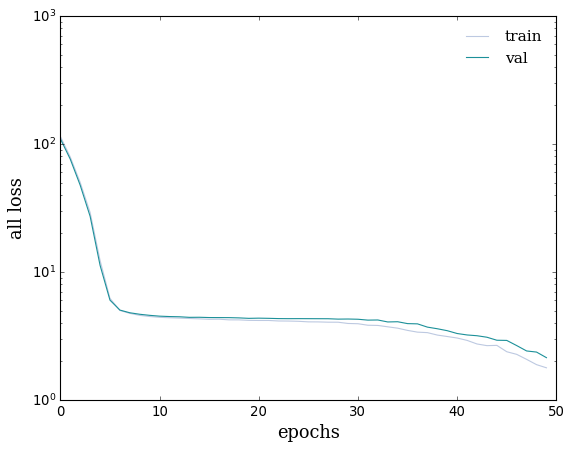

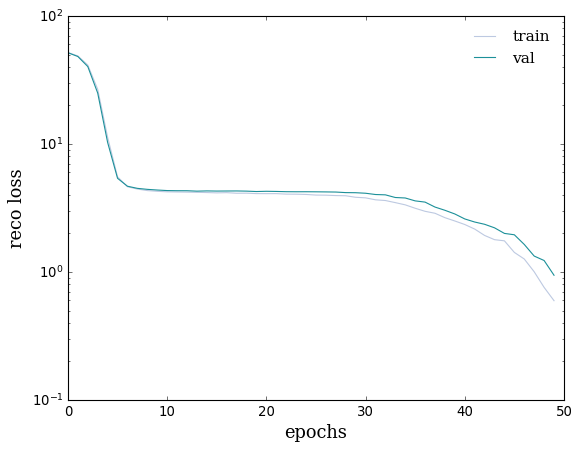

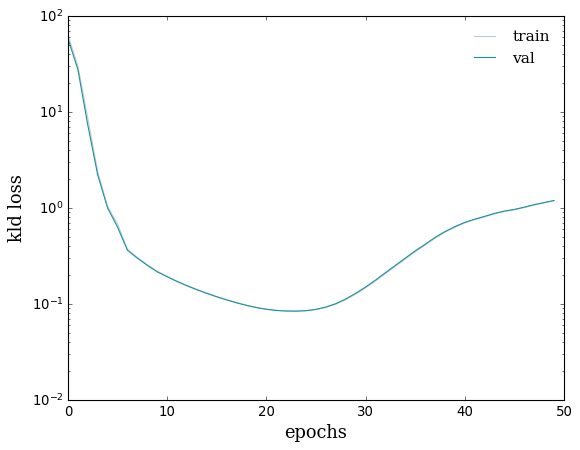

In [12]:
for label in history_labels:
    if '_train' in label:
        fig = plt.figure(figsize=(8, 6))
        fig.patch.set_facecolor('white')
        plt.plot(history[label], label='train', color='#bdc9e1')
        plt.plot(history[label.replace('train', 'val')], label='val', color='#1c9099')
        plt.ylabel(label.replace('_train', '').replace('_', ' '), fontname='serif', fontsize=16)
        plt.xlabel('epochs', fontname='serif', fontsize=16)
        plt.legend(prop=font, loc='best', frameon=False)
        plt.yscale('log')
        plt.show() 

# Test 

#### load the model on cpu

In [13]:
checkpoint = torch.load('./VAE-checkpoint')
DEVICE = torch.device('cpu')
model_cpu = Model(input_dim=input_dim, latent_dim=latent_dim, 
              hidden_dim_encoder=hidden_dim_encoder, 
              hidden_dim_decoder=hidden_dim_decoder).cpu()
model_cpu.load_state_dict(checkpoint['weights'])


<All keys matched successfully>

## test on a fresh set of background data

In [15]:
x=test_dataset[0]
x=x.view(-1, input_dim).float()
x=x.cpu()

### inspect KL and reconstruction losses

In [16]:
# compute the KL and reconstruction loss for each dimension
x_hat, mean, log_var = model_cpu(x)
reco_loss = RecoLoss(x_hat, x, reduction='none')
kld_loss = KLDLoss(mean, log_var, reduction='none')

In [17]:
print(reco_loss.shape)
print(kld_loss.shape)

torch.Size([1000000, 76])
torch.Size([1000000, 6])


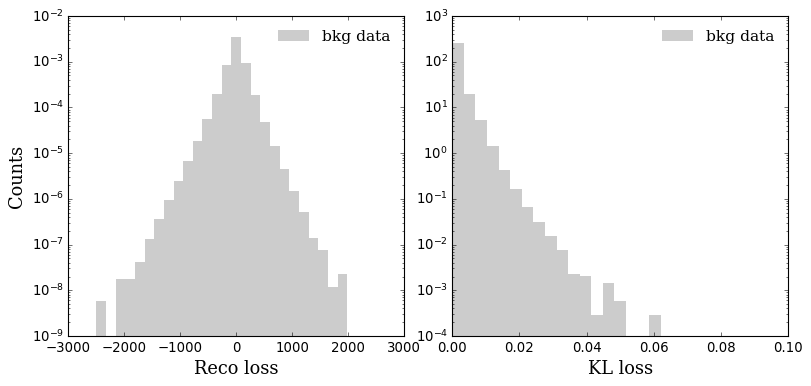

In [22]:
fig = plt.figure(figsize=(12, 5))
fig.patch.set_facecolor('white')

# plot reconstruction loss
ax = fig.add_axes([0.05, 0.1, 0.35, 0.8])
y = np.sum(reco_loss.detach().numpy(), axis=1)
bins = np.linspace(-2500, 2500, 30)
h=plt.hist(y, alpha=0.2, bins=bins, density=True, label='bkg data',color='black', ec='none')
plt.xlabel('Reco loss', fontname='serif', fontsize=16)
plt.ylabel('Counts', fontname='serif', fontsize=16)
plt.yscale('log')
plt.legend(prop=font, loc='best', frameon=False)

# plot KL loss
ax = fig.add_axes([0.45, 0.1, 0.35, 0.8])
y = np.sum(kld_loss.detach().numpy(), axis=1)
bins = np.linspace(0, 0.1, 30)
h=plt.hist(y, alpha=0.2, bins=bins, density=True, label='bkg data',color='black', ec='none')
plt.xlabel('KL loss', fontname='serif', fontsize=16)
plt.legend(prop=font, loc='best', frameon=False)
plt.yscale('log')
plt.show()

### look at the reconstruction over the marginals
A first insight on the goodness of the reconstruction can be taken inspecting the reconstructed marginal distributions and compared them with the original ones

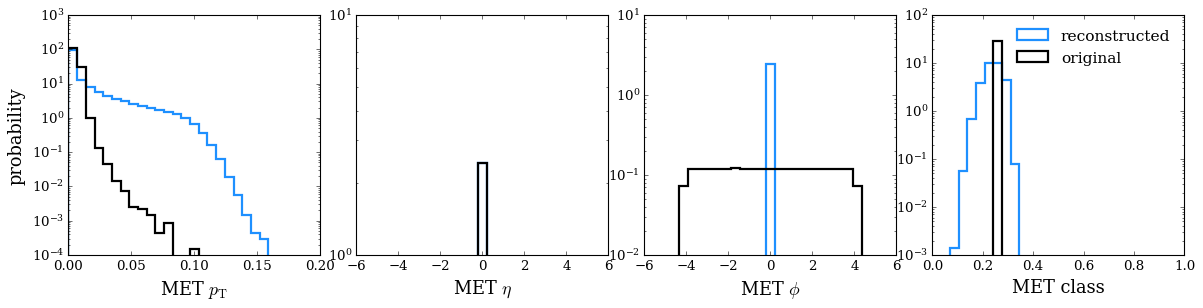

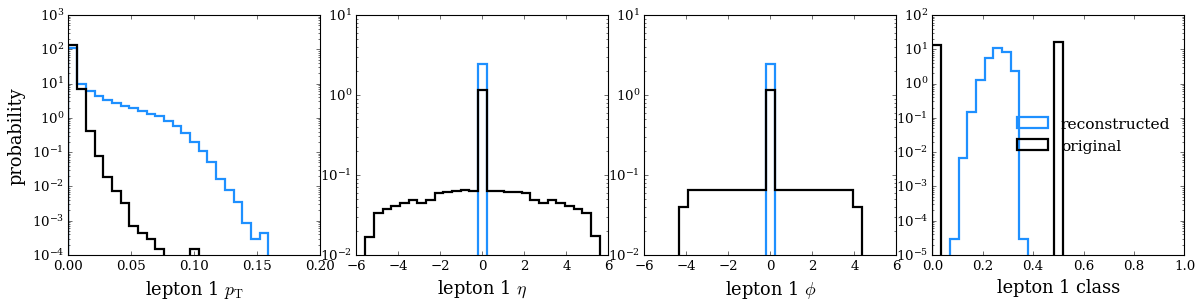

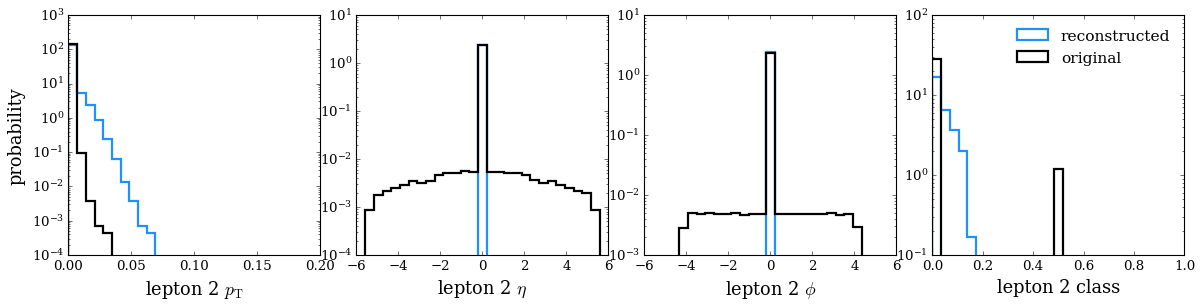

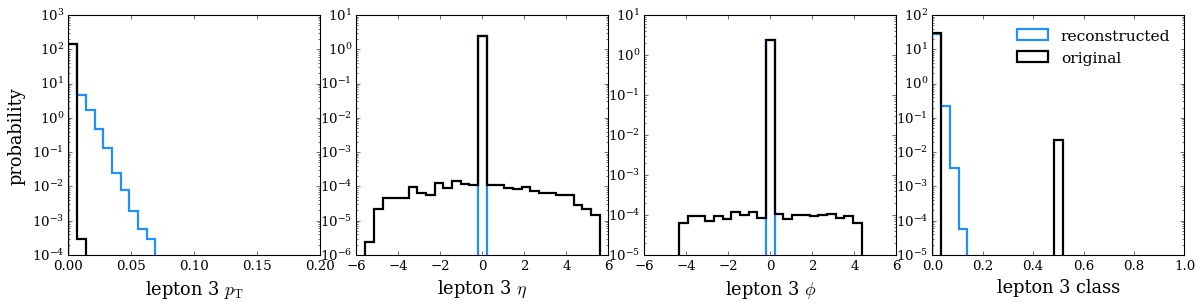

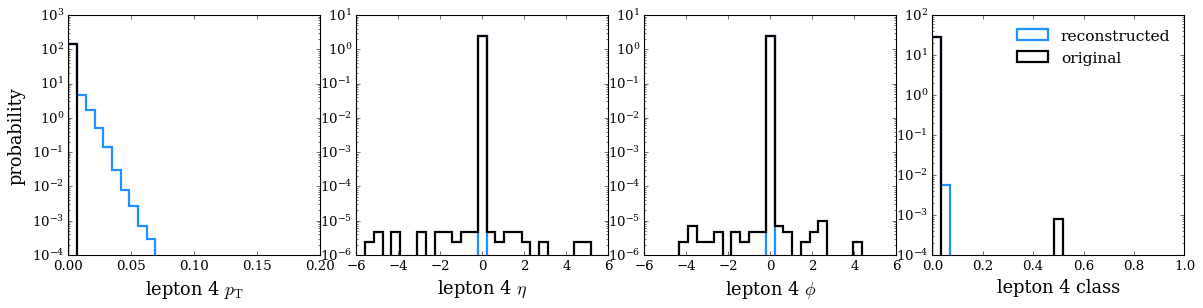

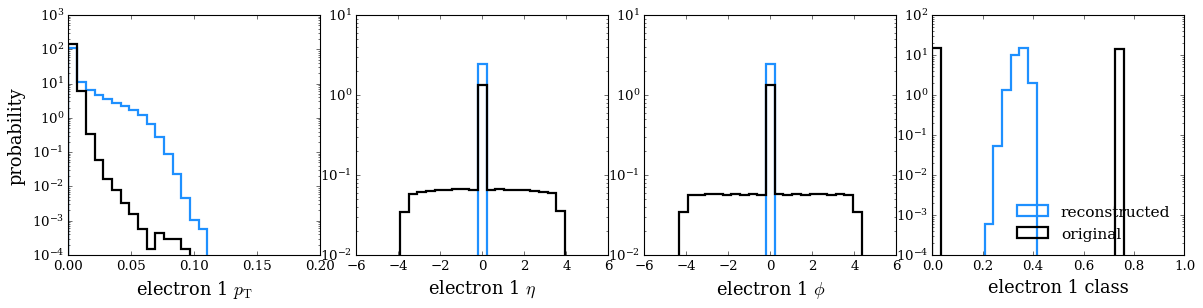

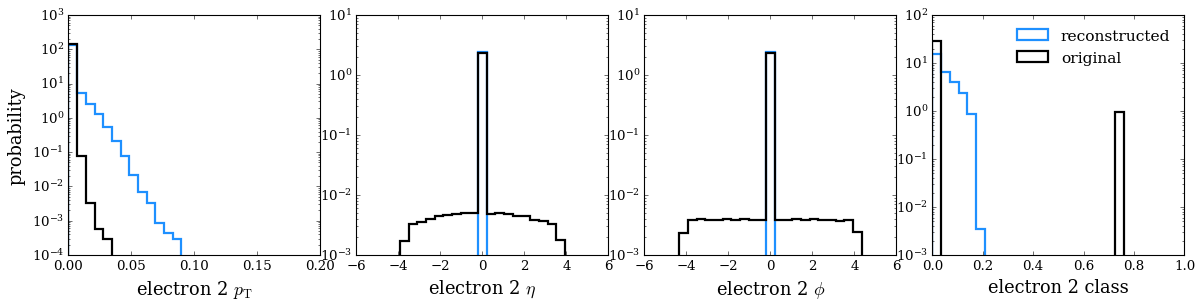

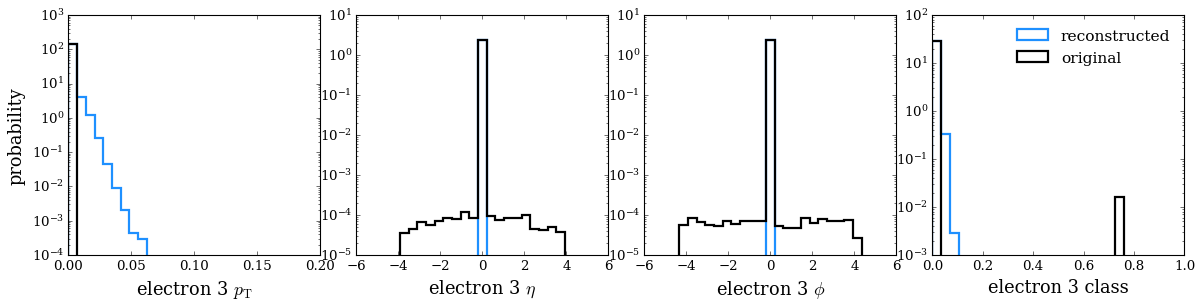

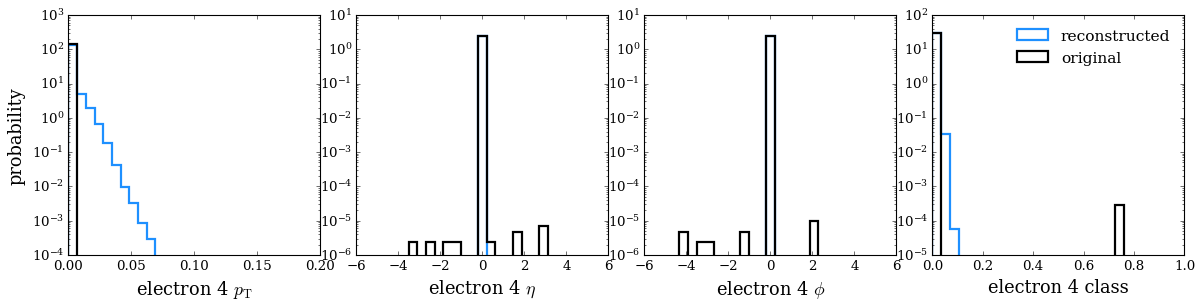

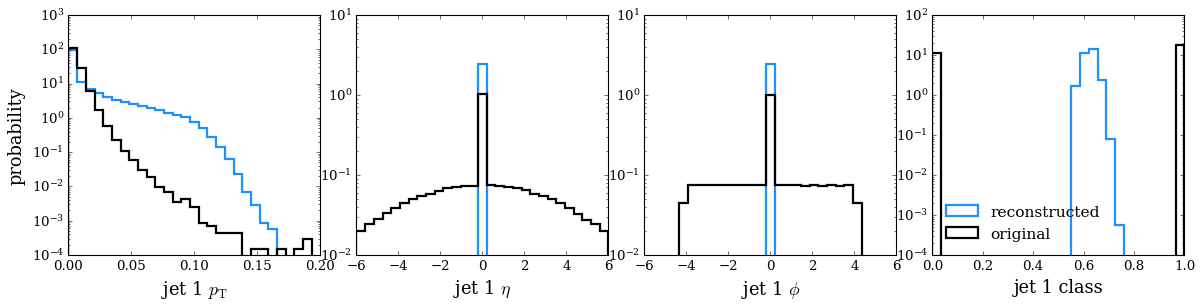

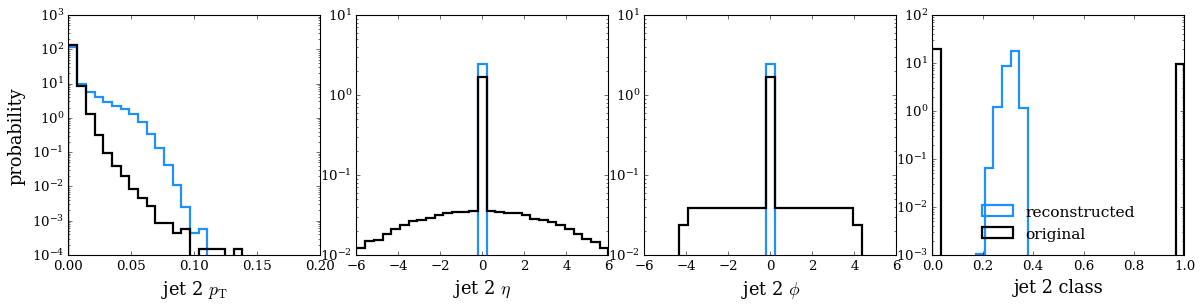

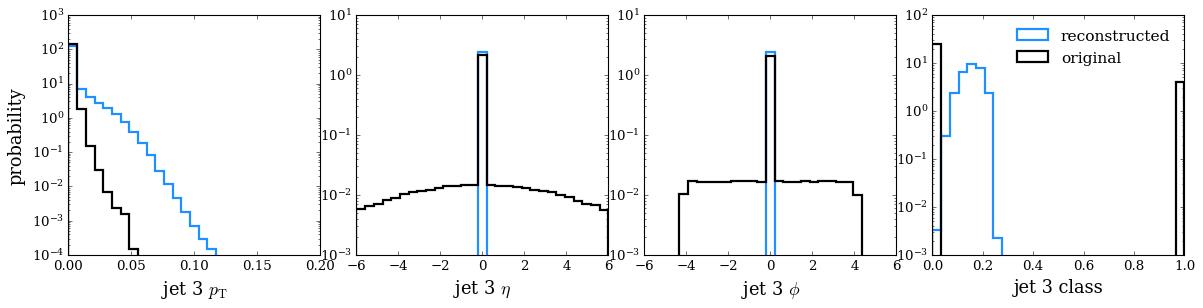

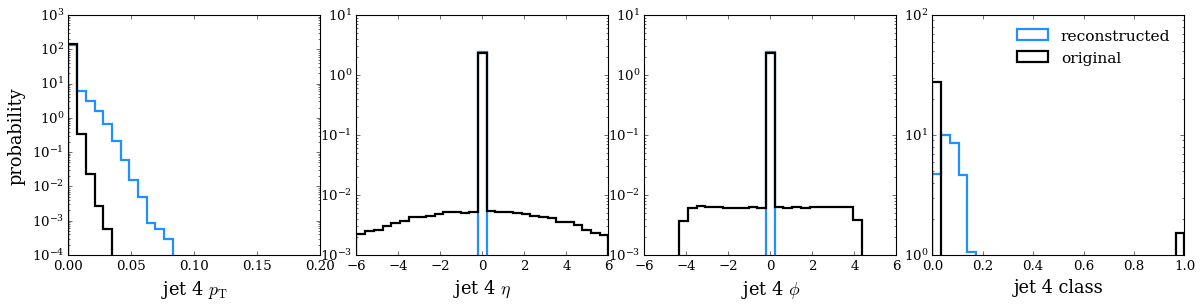

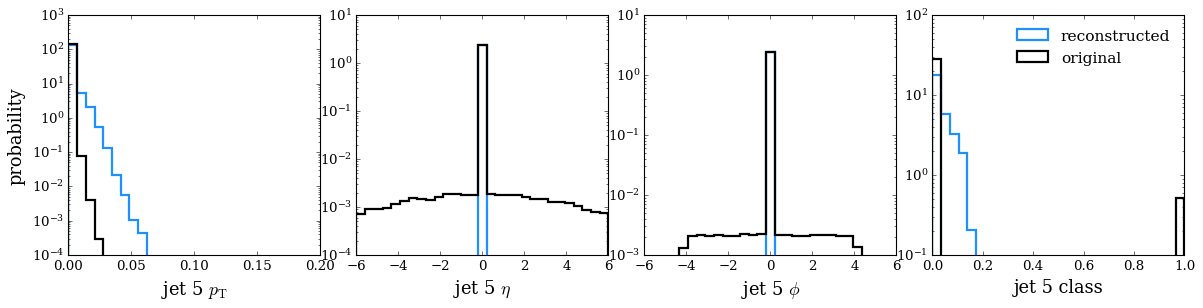

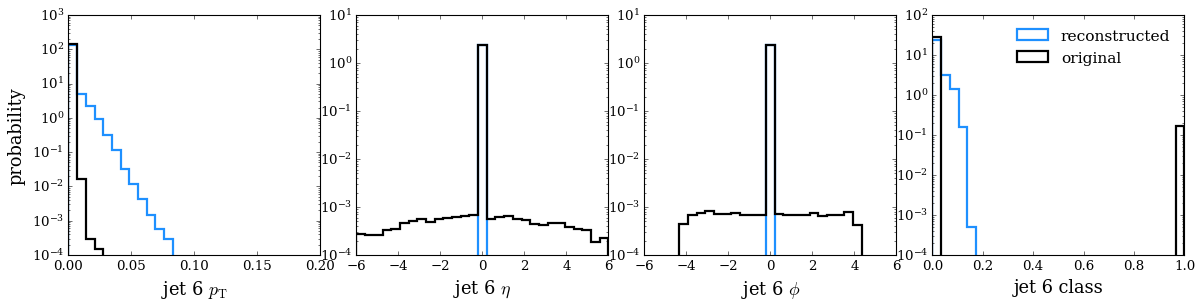

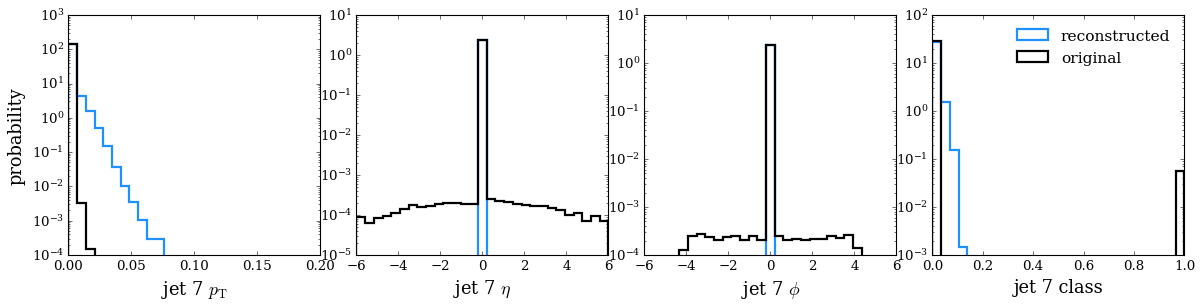

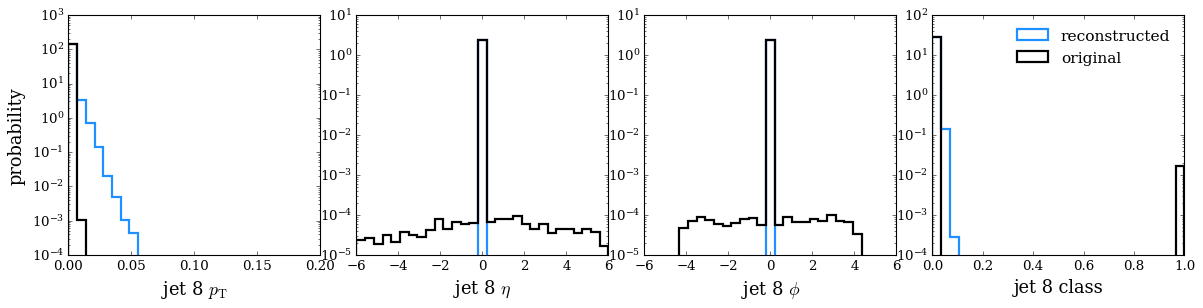

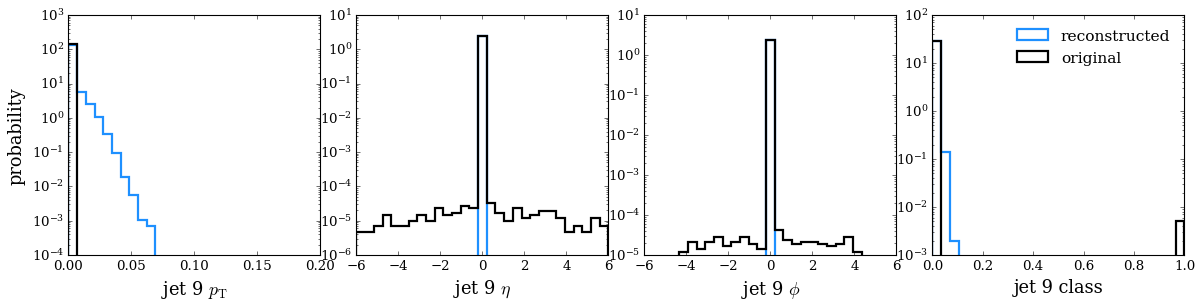

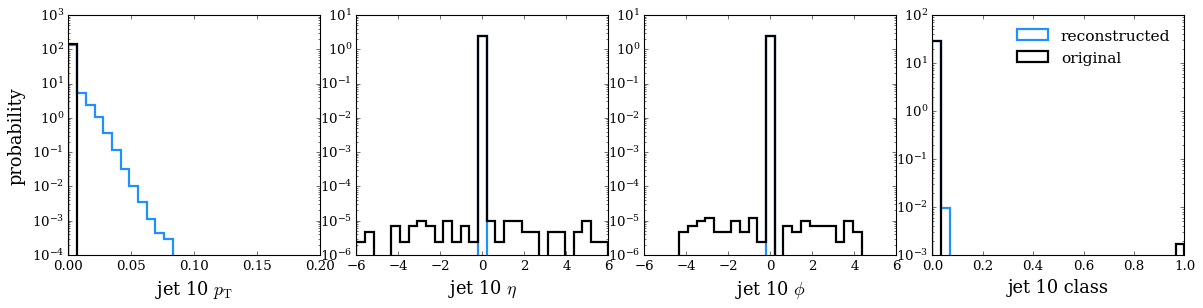

In [23]:
sm= test_dataset[0]
sm=sm.view(-1, sm.shape[1]).float()
sm=sm.cpu()
reco= x_hat.detach().numpy()
bins = [
    np.linspace(0.001, 0.2, 30),
    np.linspace(-6, 6, 30),
    np.linspace(-6, 6, 30),
    np.linspace(0, 1, 30),
       ]
# ADD !!!
# ADD !!!
# ADD !!!

### QUEST
What are your comments about the reconstruction of the merginals?

## New physics injection

### Load signal datasets

In [30]:
file = {
    'Ato4l':       './Ato4l_lepFilter_13TeV_filtered.h5',
    'hChToTauNu':  './hChToTauNu_13TeV_PU20_filtered.h5',
    'hToTauTau':   './hToTauTau_13TeV_PU20_filtered.h5',
    'leptoquark':  './leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5',
    'blackbox':    './BlackBox_background_mix.h5'
}
zenodo = {
    'Ato4l':       "10.5281/zenodo.5046445",
    'hChToTauNu':  "10.5281/zenodo.7152617",
    'hToTauTau':   "10.5281/zenodo.7152614",
    'leptoquark':  "10.5281/zenodo.7152599",
    'blackbox':    "10.5281/zenodo.5072068",
}

legend_labels_signals = {
    'Ato4l':      r'$A\rightarrow 4l$',
    'hChToTauNu': r'$h^{\pm}\rightarrow \tau^{\pm}\nu$',
    'hToTauTau':  r'$h^{0}\rightarrow \tau\tau$',
    'leptoquark': r'LQ$\rightarrow b\tau$',
    'blackbox':   'blackbox'
}
colors = {
    'Ato4l':      '#bdc9e1',
    'hChToTauNu': '#67a9cf',
    'hToTauTau':  '#1c9099',
    'leptoquark': '#016c59', 
    'blackbox':   'red'}
obj_label = ['MET', 
             'lepton 1', 'lepton 2', 'lepton 3', 'lepton 4', 
             'electron 1', 'electron 2', 'electron 3', 'electron 4',
             'jet 1', 'jet 2', 'jet 3', 'jet 4', 'jet 5', 'jet 6', 'jet 7', 'jet 8', 'jet 9', 'jet 10']
xlabel = [r'$p_{\rm T}$', r'$\eta$', r'$\phi$', 'class']
bins = [
    np.linspace(0.001, 0.5, 30),
    np.linspace(-6, 6, 30),
    np.linspace(-6, 6, 30),
    np.linspace(0, 1, 30),
       ]

In [25]:
signals = list(file.keys())
dataset_signals = {}

for signal in signals:
    print('Loading %s'%(signal))
    dataset_path = file[signal]
    if not os.path.exists(dataset_path):
        os.system("pip3 install zenodo_get")
        os.system("zenodo_get %s"%(zenodo[signal]))
    dataset_signals[signal] = torch.utils.data.TensorDataset(h5_loader(dataset_path, min_pt, max_pt, mean_eta, std_eta, mean_phi, std_phi, min_class, max_class))
    dataset_signals[signal] = dataset_signals[signal][:N_test, :]

Loading Ato4l
torch.Size([55969, 76])
Loading hChToTauNu
torch.Size([760272, 76])
Loading hToTauTau
torch.Size([691283, 76])
Loading leptoquark
torch.Size([340544, 76])
Loading blackbox
torch.Size([1001000, 76])


### plot input data distributions

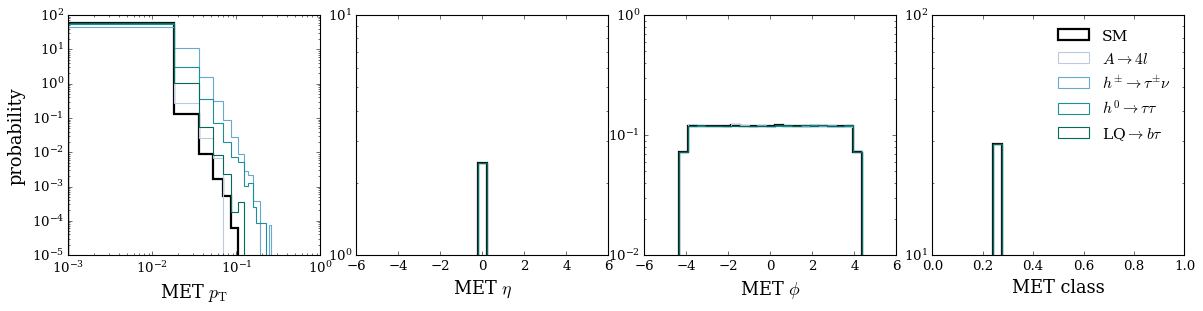

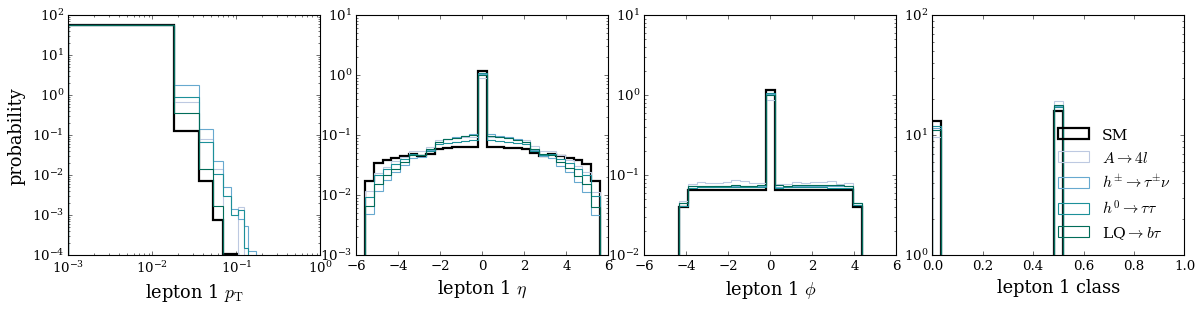

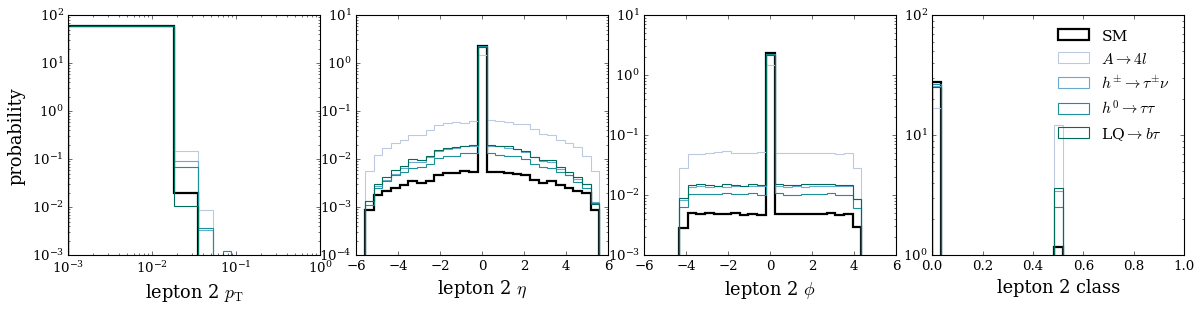

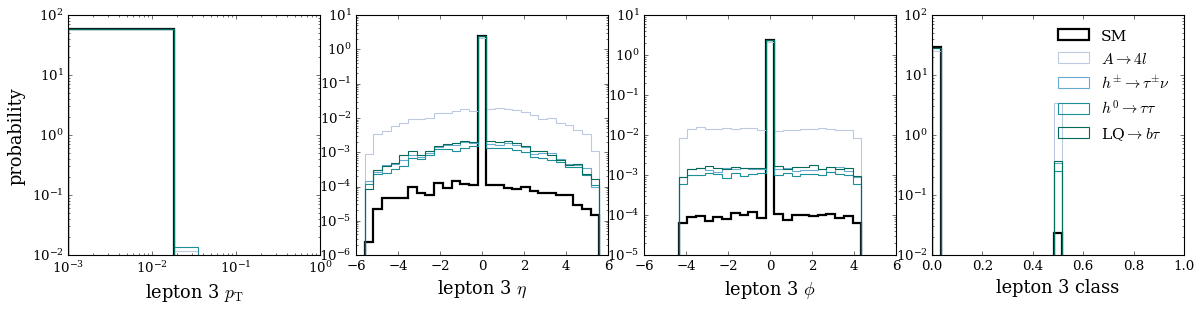

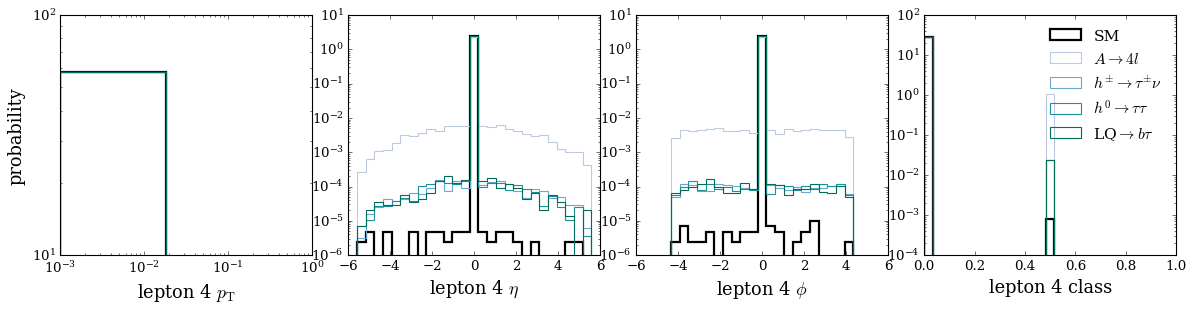

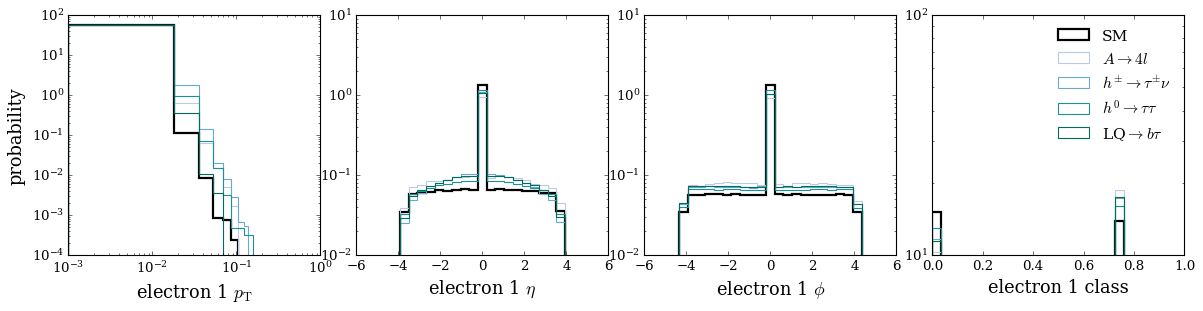

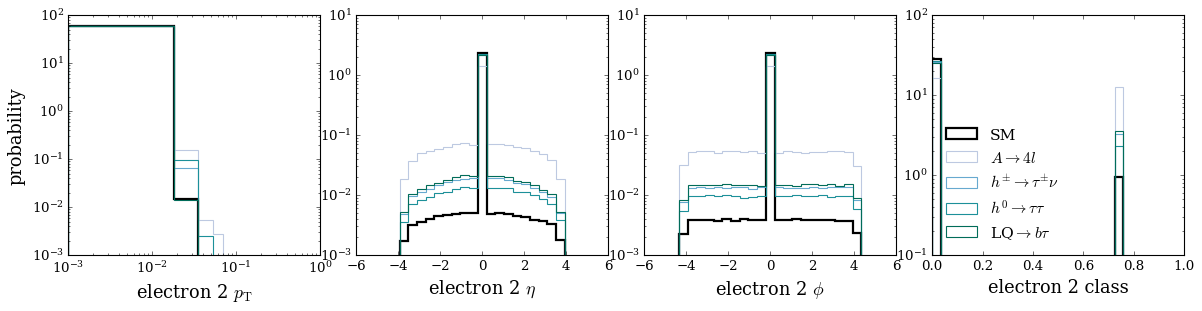

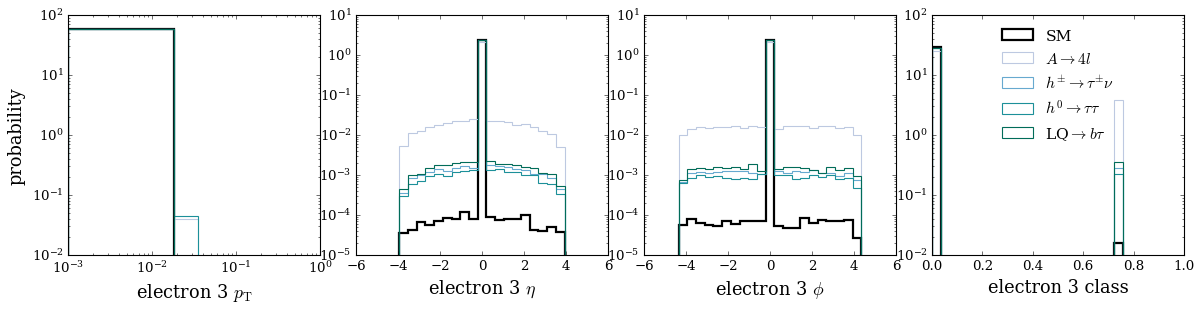

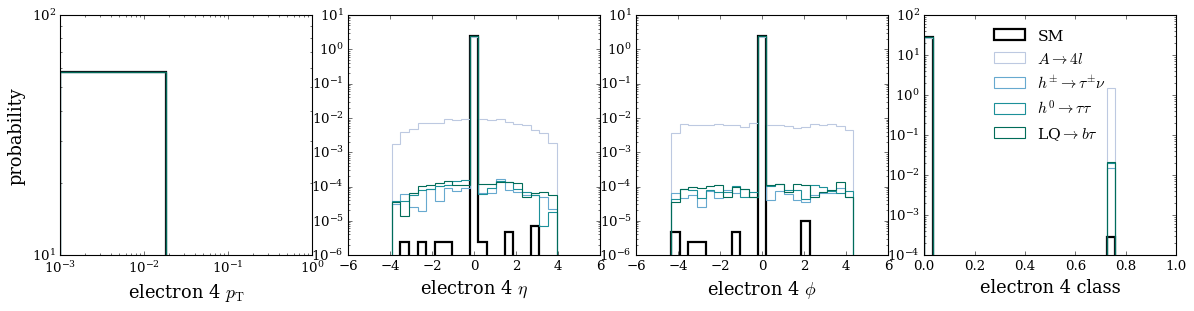

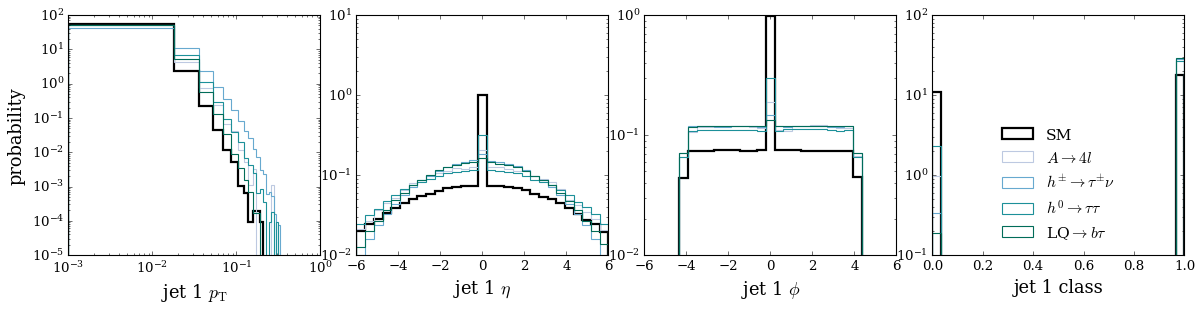

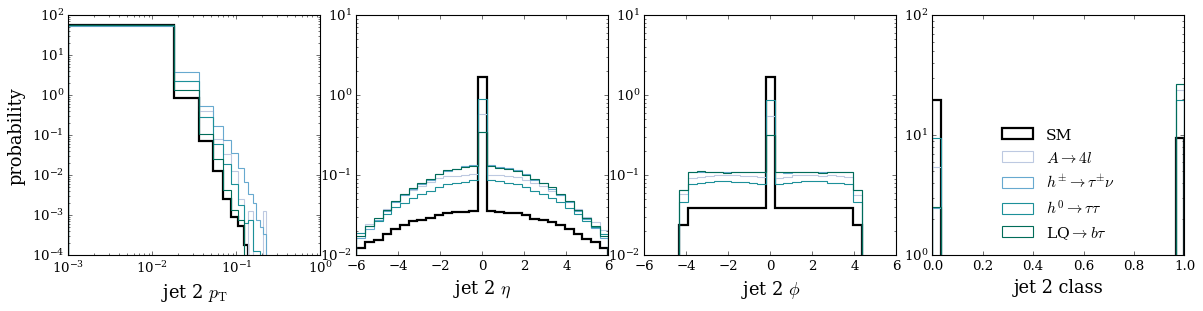

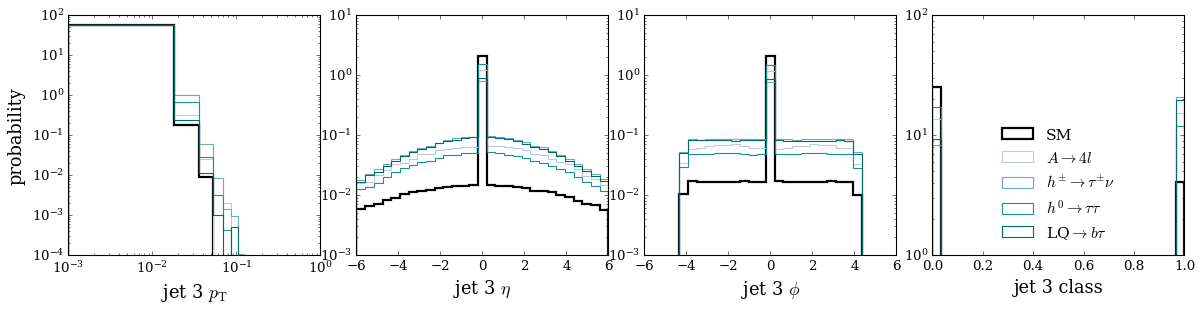

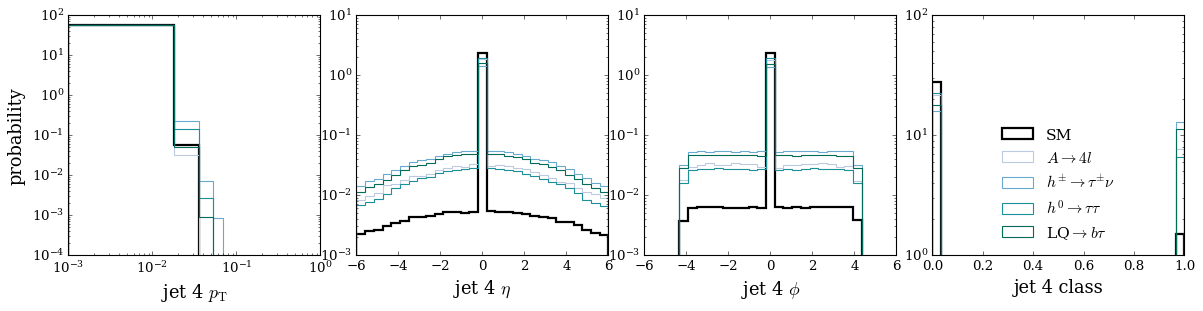

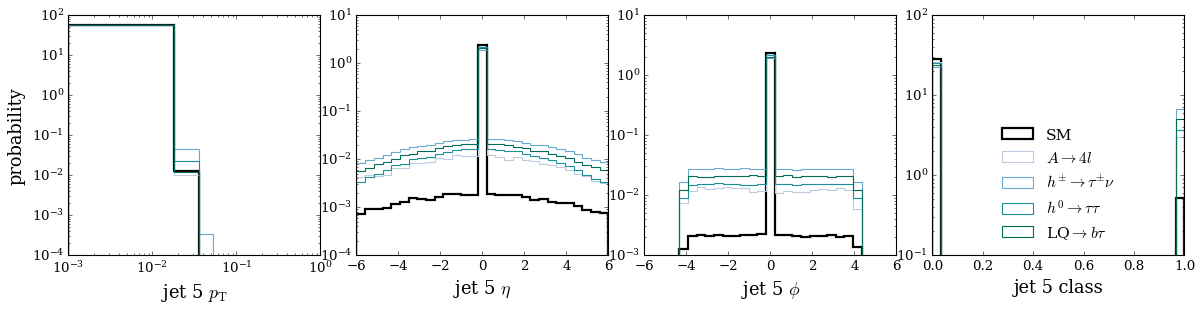

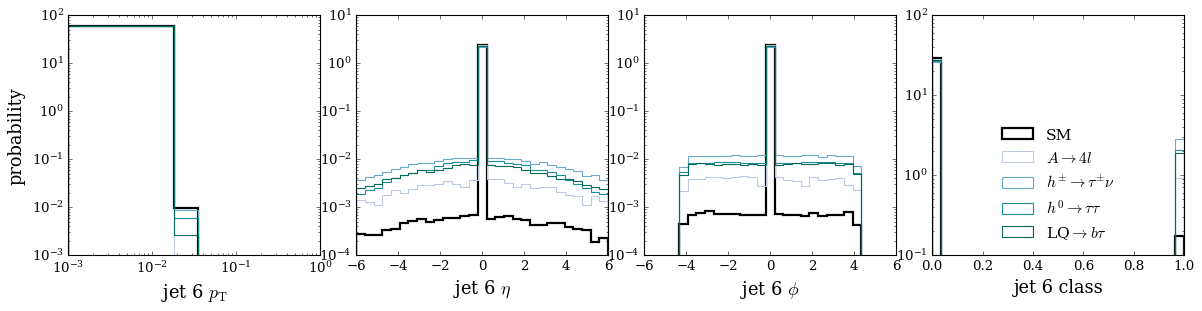

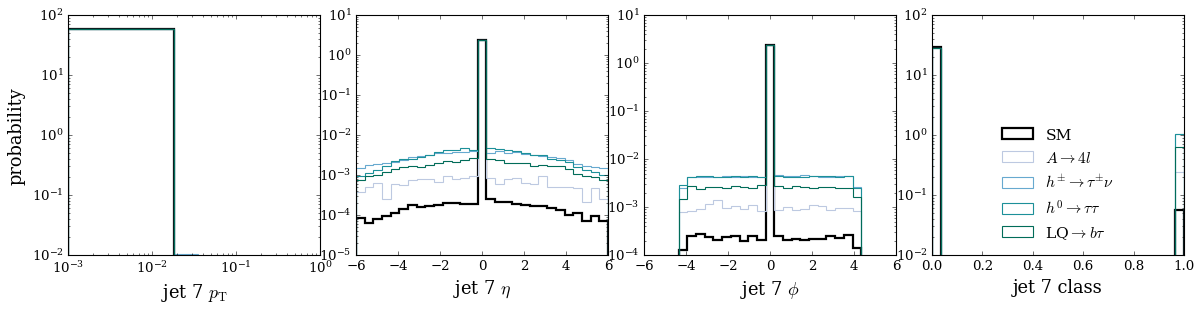

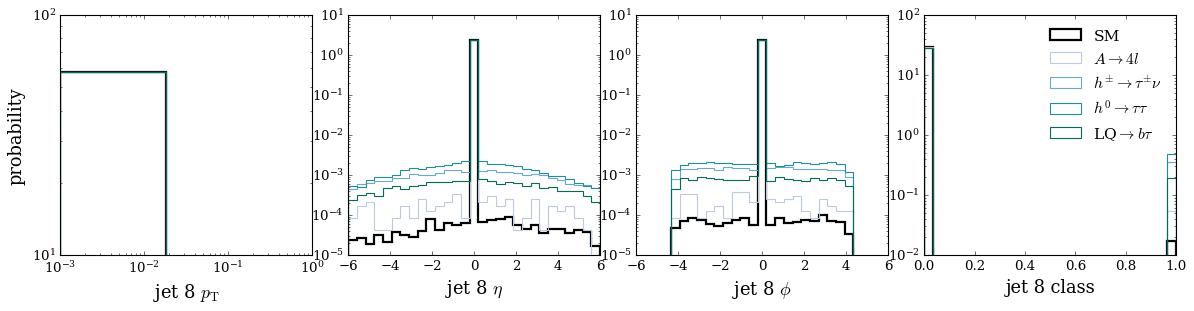

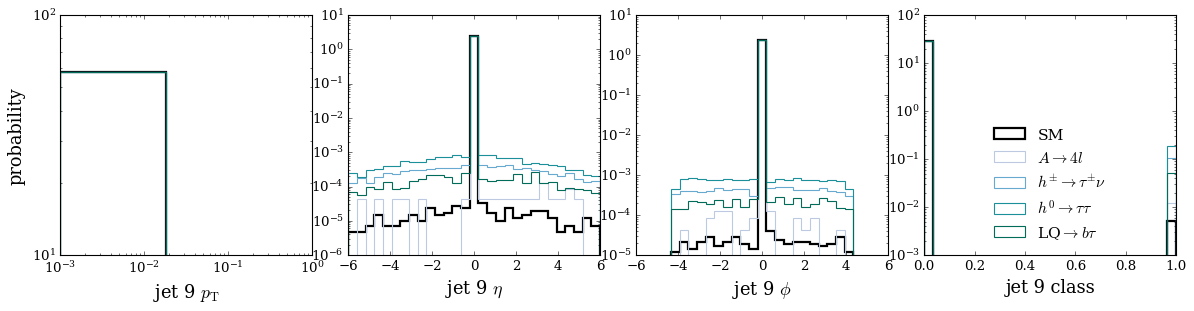

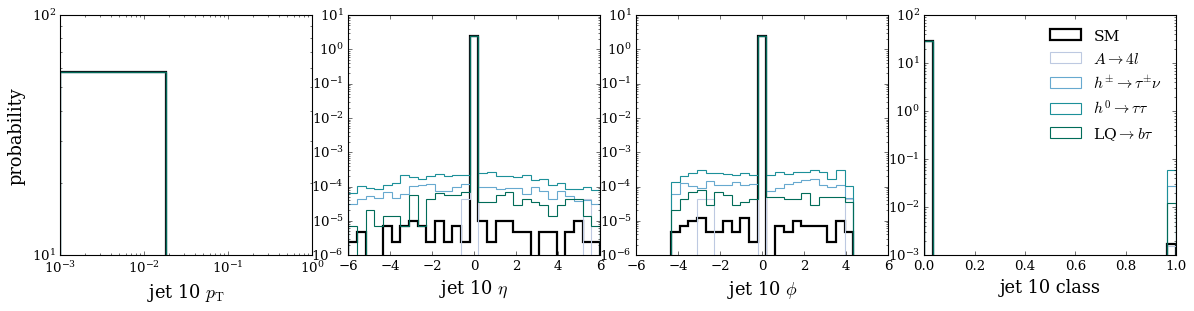

In [31]:
sm= test_dataset[0]
sm=sm.view(-1, input_dim).float()
sm=sm.cpu()

for i in range(19):
    fig = plt.figure(figsize=(15, 4))
    fig.patch.set_facecolor('white')
    for j in range(4):
        ax = fig.add_axes([0.05+0.24*j+(i*4), 0.2, 0.21, 0.75])
        h = plt.hist(sm[:, j+(i*4)], density=True, color='black', bins=bins[j], lw=2, histtype='step', label='SM')
        l=0
        for signal in signals:
            # ADD !!!
    plt.show()

# Use the loss score to select anomalies
the reconstruction loss can be used as a metric of normality. High values of the reconstruction loss mean poor quality of the generation.
This happens more frequently for events that have not been seen during training time, and are therefore considered anomalous.
Keep in mind that anomalous events in this context are rare events or out-of-dstribution ones. In distribution anomalies cannot in general be identified by selecting high values of the loss score.

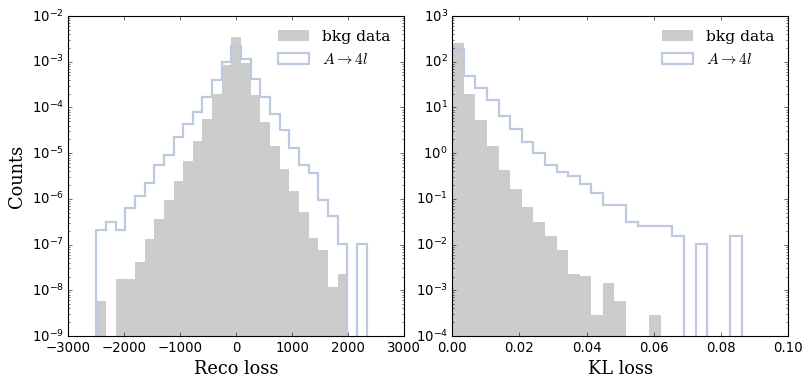

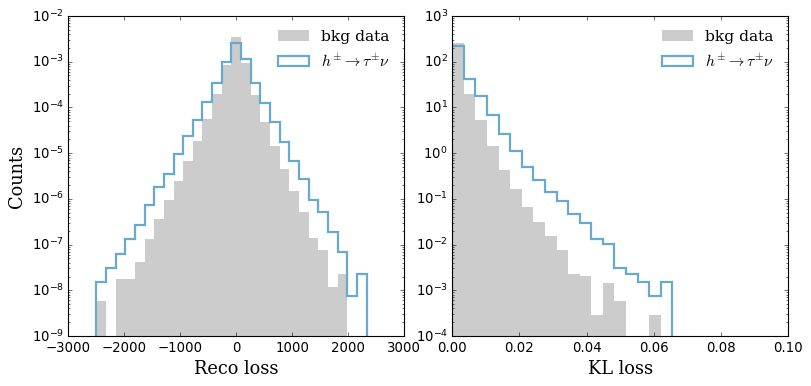

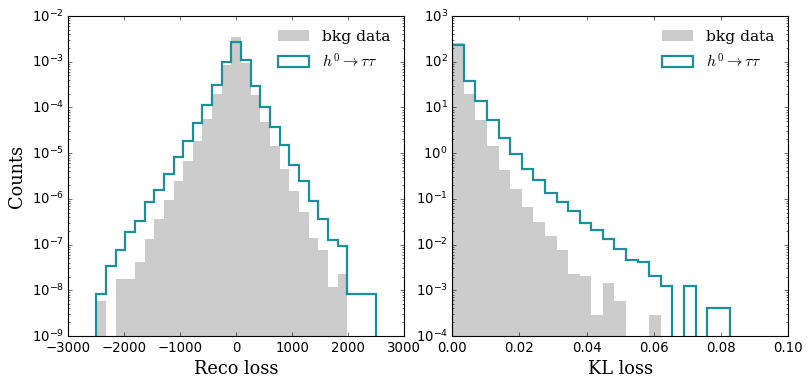

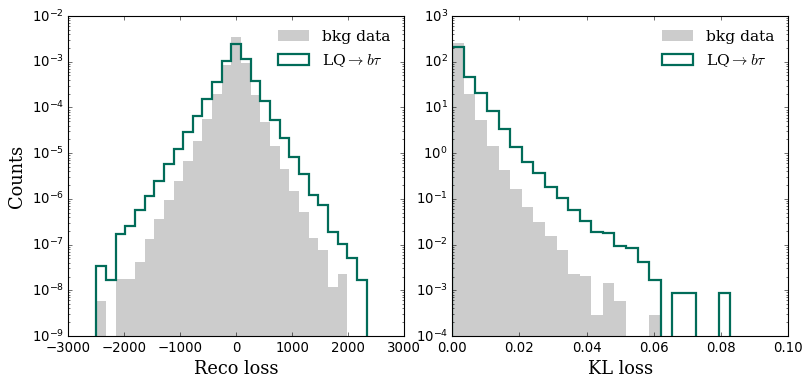

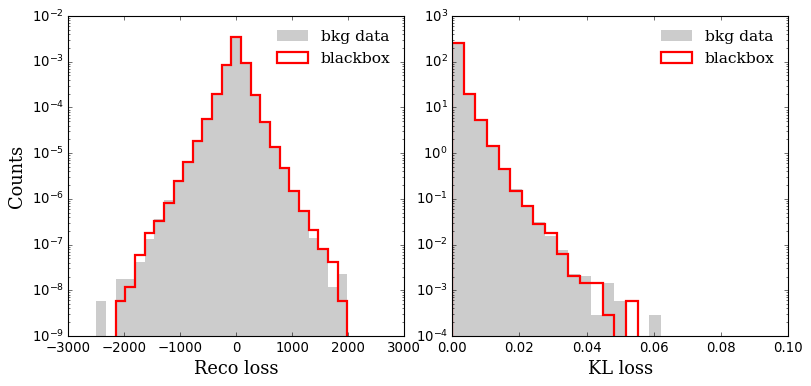

In [28]:
for signal in signals:
    x=dataset_signals[signal][0]
    x=x.view(-1, input_dim).float()
    x=x.cpu()
    x_hat, mean, log_var = model_cpu(x)
    reco_loss_sig = RecoLoss(x_hat, x, reduction='none')
    kld_loss_sig = KLDLoss(mean, log_var, reduction='none')

    fig = plt.figure(figsize=(12, 5))
    fig.patch.set_facecolor('white')
    # plot reconstruction loss
    ax = fig.add_axes([0.05, 0.1, 0.35, 0.8])
    y = np.sum(reco_loss.detach().numpy(), axis=1)
    y_sig = np.sum(reco_loss_sig.detach().numpy(), axis=1)
    bins = np.linspace(-2500, 2500, 30)
    h=plt.hist(y, alpha=0.2, bins=bins, density=True, label='bkg data',color='black', ec='none')
    plt.hist(y_sig, histtype='step', lw=2, bins=h[1], density=True, label=legend_labels_signals[signal], color=colors[signal])
    plt.xlabel('Reco loss', fontname='serif', fontsize=16)
    plt.ylabel('Counts', fontname='serif', fontsize=16)
    plt.yscale('log')
    plt.legend(prop=font, loc='best', frameon=False)

    # plot KL loss
    ax = fig.add_axes([0.45, 0.1, 0.35, 0.8])
    y = np.sum(kld_loss.detach().numpy(), axis=1)
    y_sig = np.sum(kld_loss_sig.detach().numpy(), axis=1)
    bins = np.linspace(0, 0.1, 30)
    h=plt.hist(y, alpha=0.2, bins=bins, density=True, label='bkg data',color='black', ec='none')
    plt.hist(y_sig, histtype='step', lw=2, bins=h[1], density=True, label=legend_labels_signals[signal], color=colors[signal])
    plt.xlabel('KL loss', fontname='serif', fontsize=16)
    plt.legend(prop=font, loc='best', frameon=False)
    plt.yscale('log')
    plt.show()

### QUEST 

How would you select anomalous events starting from the loss output? Do you observe failures and why?